In [19]:
import os, cv2
import torch

import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms
import numpy as np

users_path = os.path.join(os.getcwd(), 'users')

In [2]:
def save_user(root_path, username):
    
    save_path = os.path.join(root_path, username)
    if not os.path.isdir(save_path):
        os.mkdir(save_path)
    
    vid = cv2.VideoCapture(0) 

    imgs = []
    while(True): 

        # Capture the video frame 
        # by frame ppppppppq
        ret, frame = vid.read() 

        # Display the resulting frame 
        cv2.imshow('frame', frame) 

        # the 'q' button is set as the 
        # quitting button you may use any 
        # desired button of your choice 

        if cv2.waitKey(1) & 0xFF == ord('w'):
            imgs.append(frame)
            cv2.imwrite(os.path.join(save_path, '{0}.png'.format(len(imgs))), frame)
            print('{0} frames capturados'.format(len(imgs)))
            
            if len(imgs) == 10: break

        if cv2.waitKey(1) & 0xFF == ord('q'): 
            break

    # After the loop release the cap object 
    vid.release() 
    # Destroy all the windows 
    cv2.destroyAllWindows() 
    
save_user(users_path, 'mila')

1 frames capturados


# Baixe o modelo treinado para reconhecimento de faces
Demora um pouco, mas vai!

In [20]:
import requests

if not os.path.isfile('resnet50_ft_dag.pth'):
    weights_path = 'http://www.robots.ox.ac.uk/~albanie/models/pytorch-mcn/resnet50_ft_dag.pth'
    r = requests.get(weights_path, allow_redirects=True)

    open('resnet50_ft_dag.pth', 'wb').write(r.content)

In [21]:
import mtcnn
from resnet50_ft_dag import resnet50_ft_dag

detector = mtcnn.MTCNN()
model = resnet50_ft_dag()
print(model)

Resnet50_ft_dag(
  (conv1_7x7_s2): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (conv1_7x7_s2_bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv1_relu_7x7_s2): ReLU()
  (pool1_3x3_s2): MaxPool2d(kernel_size=[3, 3], stride=[2, 2], padding=(0, 0), dilation=1, ceil_mode=True)
  (conv2_1_1x1_reduce): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (conv2_1_1x1_reduce_bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2_1_1x1_reduce_relu): ReLU()
  (conv2_1_3x3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (conv2_1_3x3_bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2_1_3x3_relu): ReLU()
  (conv2_1_1x1_increase): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (conv2_1_1x1_increase_bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True

# Guardando features e métricas de referência de cada usuária

1/1 [==============================] - 0s 24ms/step
[{'box': [319, 124, 199, 260], 'confidence': 0.9996121525764465, 'keypoints': {'left_eye': (408, 218), 'right_eye': (494, 232), 'nose': (474, 255), 'mouth_left': (412, 310), 'mouth_right': (483, 322)}}]
torch.Size([2048])


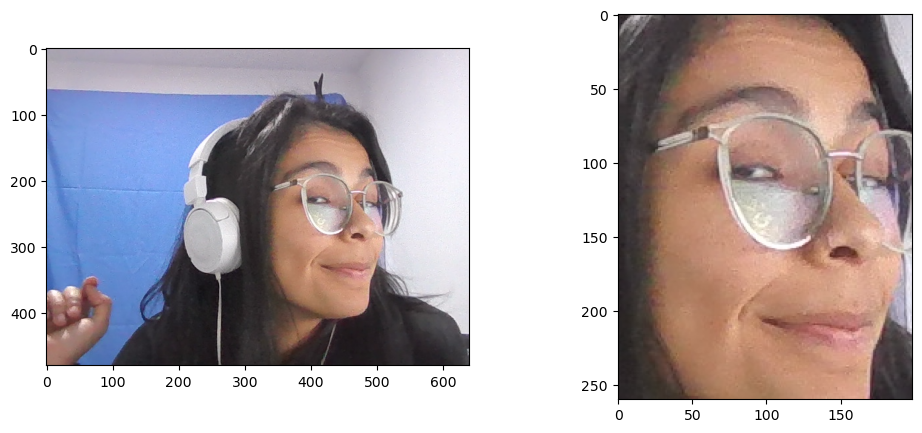

In [25]:
# Função para extração de características a partir de uma imagem
def extract_features(pixels):
    pixels = np.array(pixels, dtype=np.uint8)
    
    # Recortando a face
    faces = detector.detect_faces(pixels)
    print(faces)
    x, y, width, height = faces[0]['box']
    face = pixels[y:y+height, x:x+width]
    
    # Plot da imagem e da face recortada
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))
    axs[0].imshow(pixels)
    axs[1].imshow(face)
    
    # extrai caracteristicas de alto nível
    face = Image.fromarray(face, 'RGB')
    
    face = transforms.Resize( (224, 224) )(face)
    face = transforms.ToTensor()(face).unsqueeze(0)
    
    class_, feature = model(face) 
    
    return feature.detach().cpu().data.squeeze()
    
imagem = Image.open(os.path.join(users_path, 'mila', '9.png'))
feature = extract_features(imagem)
print(feature.shape)

In [26]:
# Função para guardar as features de referência de um dado usuário

from torch import nn

metric = nn.L1Loss()

def registra_usuario(usuario):
    
    user_path = os.path.join(users_path, usuario)
    print(user_path)
    all_features = []
    for img in os.listdir(user_path):
        if img[-3:] != 'png': continue
        print(user_path)
        print(img)
        pixels = Image.open(os.path.join(user_path, img))
        feature = extract_features(pixels)
        
        all_features.append(feature)
        
    all_losses = []
    for k in range(len(all_features)):
        for j, feat in enumerate(all_features):
            if k == j: continue
            all_losses.append(metric(all_features[k], feat) )
    
    
    all_losses = np.asarray(all_losses)
    print(np.mean(all_losses), np.std(all_losses))
    
    all_features = np.asarray([feat.numpy() for feat in all_features])
    np.savez_compressed(os.path.join(user_path, 'referencia'), all_feats=all_features, 
                                                          mean=np.mean(all_losses),
                                                          std=np.std(all_losses))
    


Mila
/project/notebooks/users/mila
/project/notebooks/users/mila
1.png
1/1 [==============================] - 0s 49ms/step
[{'box': [229, 148, 207, 284], 'confidence': 0.9999924898147583, 'keypoints': {'left_eye': (291, 247), 'right_eye': (392, 258), 'nose': (343, 297), 'mouth_left': (280, 346), 'mouth_right': (381, 361)}}]
/project/notebooks/users/mila
10.png
1/1 [==============================] - 0s 20ms/step
[{'box': [259, 119, 206, 295], 'confidence': 0.9999963045120239, 'keypoints': {'left_eye': (313, 229), 'right_eye': (414, 238), 'nose': (360, 299), 'mouth_left': (299, 317), 'mouth_right': (418, 326)}}]
/project/notebooks/users/mila
2.png
1/1 [==============================] - 0s 20ms/step
[{'box': [275, 136, 208, 269], 'confidence': 0.9991897940635681, 'keypoints': {'left_eye': (364, 240), 'right_eye': (451, 252), 'nose': (417, 275), 'mouth_left': (364, 320), 'mouth_right': (442, 334)}}]
/project/notebooks/users/mila
3.png
1/1 [==============================] - 0s 24ms/step
[{'

2022-11-14 20:44:19.124231: W tensorflow/core/framework/op_kernel.cc:1780] OP_REQUIRES failed at conv_ops_fused_impl.h:719 : INVALID_ARGUMENT: input depth must be evenly divisible by filter depth: 4 vs 3


InvalidArgumentError: Graph execution error:

Detected at node 'model_3/conv2d_12/BiasAdd' defined at (most recent call last):
    File "/opt/conda/lib/python3.9/runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/opt/conda/lib/python3.9/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/opt/conda/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/opt/conda/lib/python3.9/site-packages/traitlets/config/application.py", line 978, in launch_instance
      app.start()
    File "/opt/conda/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 712, in start
      self.io_loop.start()
    File "/opt/conda/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "/opt/conda/lib/python3.9/asyncio/base_events.py", line 601, in run_forever
      self._run_once()
    File "/opt/conda/lib/python3.9/asyncio/base_events.py", line 1905, in _run_once
      handle._run()
    File "/opt/conda/lib/python3.9/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/opt/conda/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "/opt/conda/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "/opt/conda/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 406, in dispatch_shell
      await result
    File "/opt/conda/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 730, in execute_request
      reply_content = await reply_content
    File "/opt/conda/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 383, in do_execute
      res = shell.run_cell(
    File "/opt/conda/lib/python3.9/site-packages/ipykernel/zmqshell.py", line 528, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/opt/conda/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 2885, in run_cell
      result = self._run_cell(
    File "/opt/conda/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 2940, in _run_cell
      return runner(coro)
    File "/opt/conda/lib/python3.9/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/opt/conda/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3139, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/opt/conda/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3318, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/opt/conda/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3378, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_87/4176252447.py", line 4, in <module>
      registra_usuario(user)
    File "/tmp/ipykernel_87/3036969937.py", line 16, in registra_usuario
      feature = extract_features(pixels)
    File "/tmp/ipykernel_87/3968674996.py", line 6, in extract_features
      faces = detector.detect_faces(pixels)
    File "/opt/conda/lib/python3.9/site-packages/mtcnn/mtcnn.py", line 300, in detect_faces
      result = stage(img, result[0], result[1])
    File "/opt/conda/lib/python3.9/site-packages/mtcnn/mtcnn.py", line 342, in __stage1
      out = self._pnet.predict(img_y)
    File "/opt/conda/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/opt/conda/lib/python3.9/site-packages/keras/engine/training.py", line 2253, in predict
      tmp_batch_outputs = self.predict_function(iterator)
    File "/opt/conda/lib/python3.9/site-packages/keras/engine/training.py", line 2041, in predict_function
      return step_function(self, iterator)
    File "/opt/conda/lib/python3.9/site-packages/keras/engine/training.py", line 2027, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/opt/conda/lib/python3.9/site-packages/keras/engine/training.py", line 2015, in run_step
      outputs = model.predict_step(data)
    File "/opt/conda/lib/python3.9/site-packages/keras/engine/training.py", line 1983, in predict_step
      return self(x, training=False)
    File "/opt/conda/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/opt/conda/lib/python3.9/site-packages/keras/engine/training.py", line 557, in __call__
      return super().__call__(*args, **kwargs)
    File "/opt/conda/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/opt/conda/lib/python3.9/site-packages/keras/engine/base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/opt/conda/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/opt/conda/lib/python3.9/site-packages/keras/engine/functional.py", line 510, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "/opt/conda/lib/python3.9/site-packages/keras/engine/functional.py", line 667, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "/opt/conda/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/opt/conda/lib/python3.9/site-packages/keras/engine/base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/opt/conda/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/opt/conda/lib/python3.9/site-packages/keras/layers/convolutional/base_conv.py", line 304, in call
      outputs = tf.nn.bias_add(
Node: 'model_3/conv2d_12/BiasAdd'
input depth must be evenly divisible by filter depth: 4 vs 3
	 [[{{node model_3/conv2d_12/BiasAdd}}]] [Op:__inference_predict_function_28334]

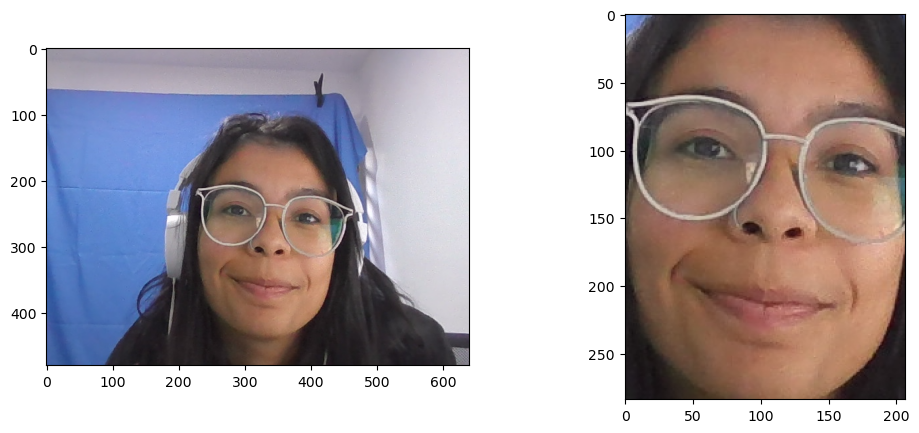

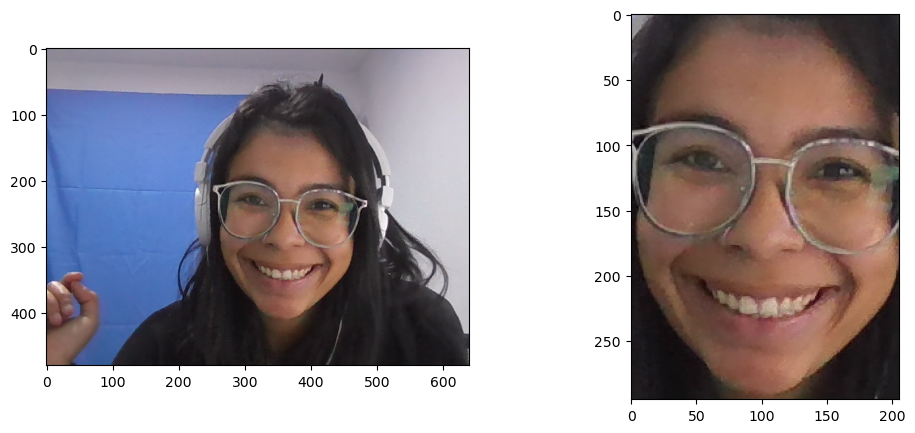

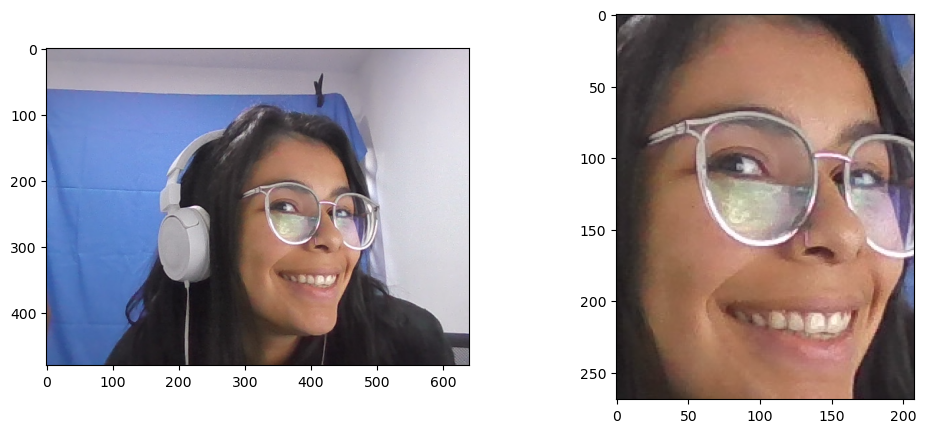

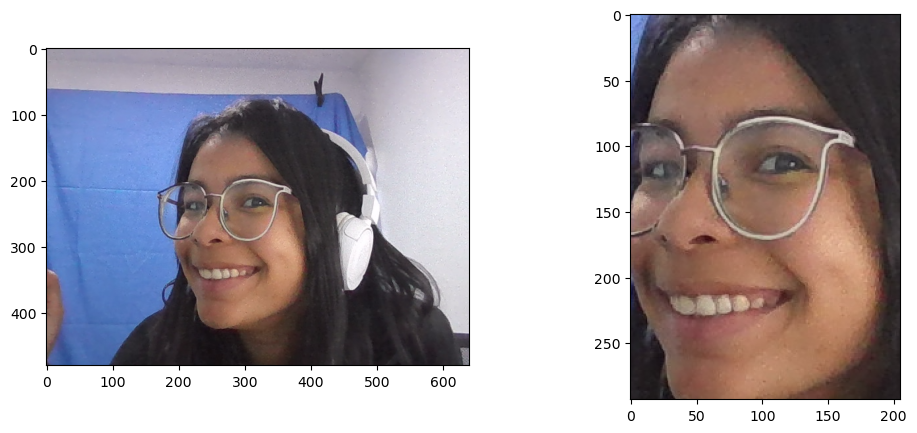

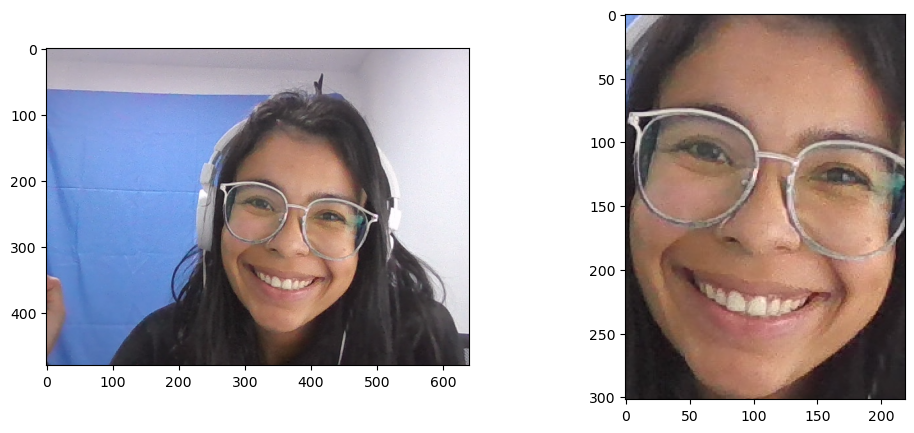

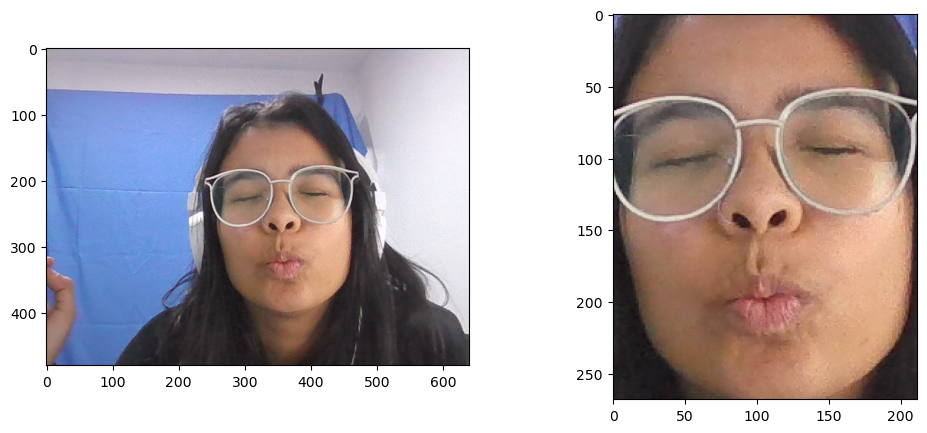

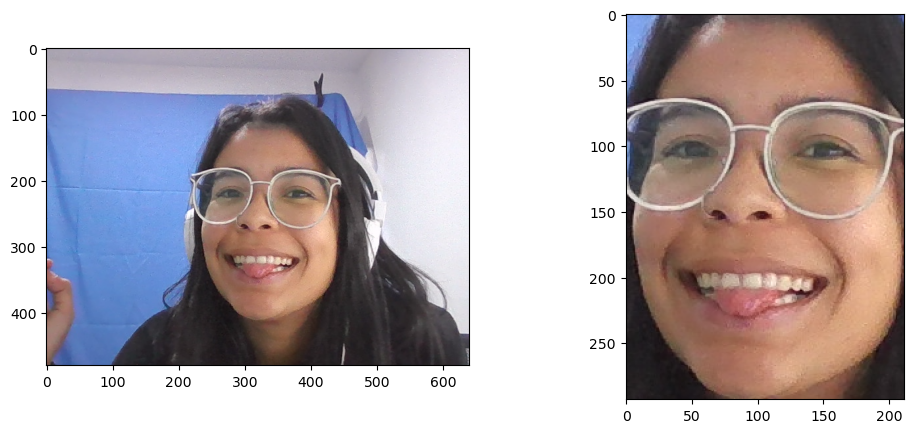

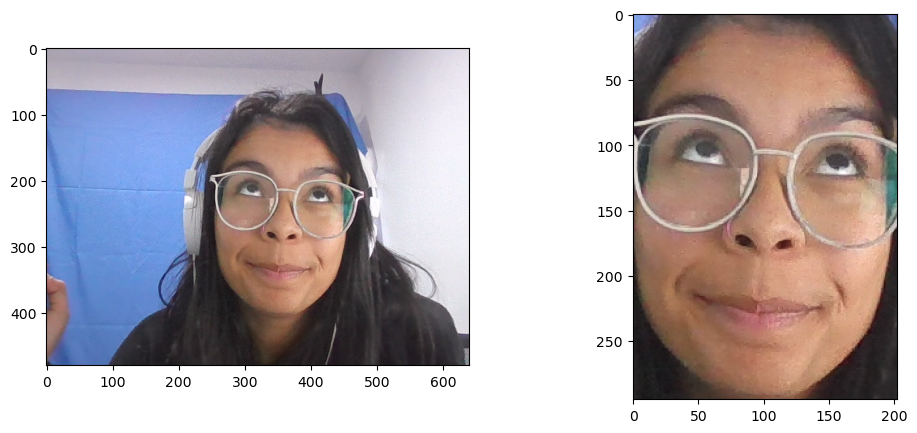

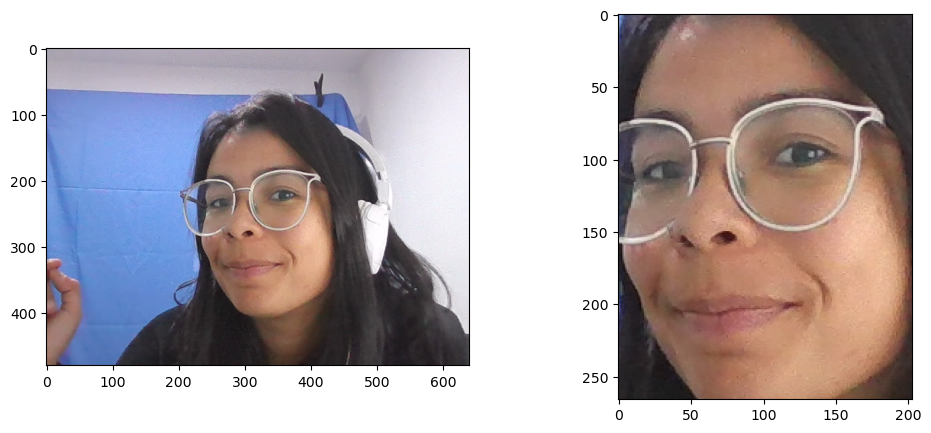

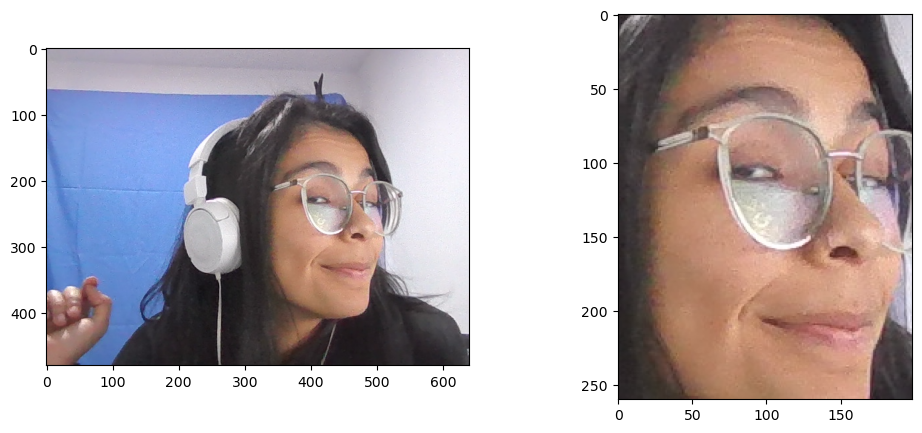

In [17]:
# Iteração em todos os usuários
for user in os.listdir(users_path):
    print(user.capitalize())
    registra_usuario(user)

# Teste com imagens nunca antes vistas!

In [9]:
def get_new_img():

    vid = cv2.VideoCapture(0) 

    ret = []
    while(True): 
        ret, frame = vid.read() 
        cv2.imshow('frame', frame) 

        if cv2.waitKey(1) & 0xFF == ord('w'):
            ret = frame
            print('1 frame capturado')
            break

        if cv2.waitKey(1) & 0xFF == ord('q'): 
            break

    vid.release() 
    cv2.destroyAllWindows() 
    
    return ret

1/1 [==============================] - 0s 22ms/step
[{'box': [319, 124, 199, 260], 'confidence': 0.9996121525764465, 'keypoints': {'left_eye': (408, 218), 'right_eye': (494, 232), 'nose': (474, 255), 'mouth_left': (412, 310), 'mouth_right': (483, 322)}}]
Identidade: Mila


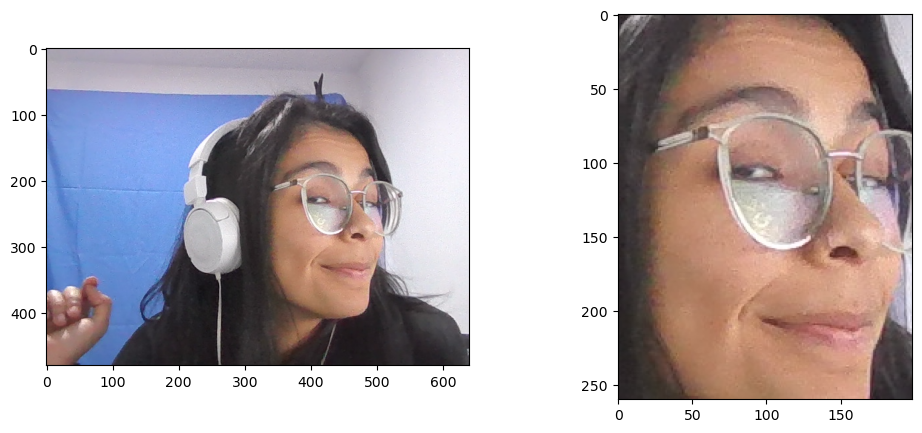

In [27]:
# Pega nova imagem
#pixels = cv2.cvtColor(get_new_img(), cv2.COLOR_BGR2RGB)
pixels = Image.open(os.path.join('/project/notebooks/users/mila/', '9.png'))
feature = extract_features( pixels )

# Compara feature da nova imagem com as referências
# previamente armazenadas.
reconhecido = False
for user in os.listdir(users_path):
    
    referencia = np.load(os.path.join(users_path, user, 'referencia.npz'))
    all_features = referencia['all_feats']
    mean = referencia['mean']
    std  = referencia['std']
    
    all_dist = []
    for feat in all_features:
        all_dist.append(metric(feature, torch.from_numpy(feat) ))
        
    # Critério de identificação. Para cada usuário:
    #    calcule a média da distância da nova imagem com todas as imagens de referência
    #    compare com a média da diferença das imagens de referência entre si
    #    se a diferença estiver dentro de 1 desvio padrão, é possível que seja a pessoa!
    
    if abs( np.mean(all_dist) - mean ) < std:
        print('Identidade:', user.capitalize())
        reconhecido = True
        
if not reconhecido:
    print('Usuário não identificado')
    
